# Using *mdx2* in python (advanced)

Run these imports first:

In [19]:
# for loading mdx2 objects in python
from mdx2.utils import loadobj, saveobj

# for creating mdx2 tables
from mdx2.data import HKLTable

# for calculating statistics
import numpy as np
import pandas as pd

# for making plots
import matplotlib.pyplot as plt

## Geometry (*numpy* and *matplotlib*)

### The Miller index array

The scan-varying model refined by DIALS is not imported explicitly. Instead, `mdx2.import_geometry` stores a 3d arrays of Miller indices (h,k,l). When `mdx2` creates a reciprocal space map (`mdx2.integrate`), these arrays are interpolated at each pixel position and phi angle. The advantage is that, after importing, `mdx2` does not need to know the details of the diffraction geometry. The code is mostly matrix math written in numpy.

Let's play with the Miller index arrays.

Reading miller_index from geometry.nxs
  importing as MillerIndex from mdx2.geometry


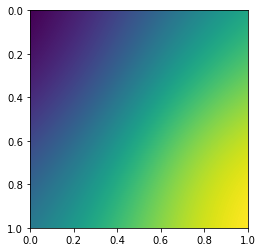

In [7]:
# load the miller index maps

mi = loadobj('geometry.nxs','miller_index')

ax = plt.imshow(mi.h[0,:,:],extent=[0,1,1,0])

The Miller index arrays are three dimensional, with axes of phi, iy, ix (phi in units of degrees, ix, iy in units of pixels)

In [8]:
print(mi.h.shape)

(51, 254, 248)


The Miller indices are related to the cartesian reciprocal space vector s, in the crystal frame. The DIALS documentation [has a nice discussion](https://dials.github.io/documentation/conventions.html) of diffraction geometry conventions. In their notation,

$$s = \mathbf{U}\mathbf{B}h$$

The $\mathbf{B}$ matrix is computed from the unit cell parameters, and $\mathbf{U}$ is a rotation matrix that sets the crystal orientation (e.g. at $\phi$ = 0).

In `geometry.nxs`, the product UB is stored.

In [9]:
crystal = loadobj('geometry.nxs','crystal')
UB = crystal.ub_matrix

print('\nUB =\n',UB)

Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry

UB =
 [[ 1.016778e-02 -7.262650e-03  1.414808e-03]
 [ 7.399073e-03  9.992527e-03 -1.880050e-03]
 [-3.843866e-05  2.352614e-03  1.235294e-02]]


The unit cell volume can be computed easily from UB:

$$\text{cell volume} = \det{(\mathbf{B}^{-1})} = (\det{\mathbf{B}})^{-1} = (\det{\mathbf{UB}})^{-1} $$

($\mathbf{U}$ is a pure rotation, so $\det{\mathbf{U}} = 1$)

In [10]:
print('cell volume =',1/np.linalg.det(UB))

cell volume = 502889.4459299761


The unit cell parameters and U matrix are also stored. These are redundant with the UB matrix, but are stored for record-keeping purposes:

In [11]:
a,b,c,alpha,beta,gamma = crystal.unit_cell
U = crystal.orientation_matrix
print('a =',a)
print('b =',b)
print('c =',c)
print('alpha =',alpha)
print('beta =',beta)
print('gamma =',gamma)
print('U = \n',U)

a = 79.52264934507161
b = 79.5226493450716
c = 79.52264934507161
alpha = 90.00000000000001
beta = 90.0
gamma = 90.0
U = 
 [[ 0.808569 -0.577545  0.112509]
 [ 0.588394  0.794632 -0.149507]
 [-0.003057  0.187086  0.982339]]


We can also calculate cell volume from the unit cell parameters. How does this compare with what we calculated from UB, above?

In [12]:
print('cell volume =',a*b*c) # easy since all angles are 90 degrees

cell volume = 502889.44592997595


### Matrix math with Miller indices

Let's compute the scattering vector magnitude across the detector face using $s = \mathbf{UB}h$.

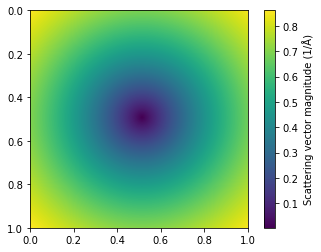

In [13]:
# example of computing the scattering vector magnitude for a particular frame
h = mi.h[0,:,:]
k = mi.k[0,:,:]
l = mi.l[0,:,:]
svec = np.tensordot(UB,np.stack((h,k,l)),axes=1) # s = UBh
s = np.sqrt(np.sum(svec**2,axis=0))

# plot of scattering vector magnitude on detector surface
plt.imshow(s,extent=[0,1,1,0])
plt.colorbar(label='Scattering vector magnitude (1/Å)')

The resolution is $1/|s|$. Let's calculate the maximum resolution (at detector corner)

In [14]:
print(f'The maximum resolution is {1/np.max(s):.2f} Å')

The maximum resolution is 1.16 Å


We can use a contour plot to draw resolution rings on the surface of the detector.

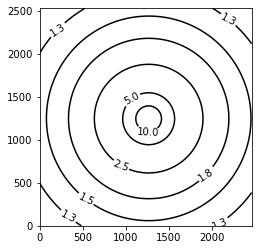

In [15]:
fig, ax = plt.subplots()
[X,Y] = np.meshgrid(mi.ix,mi.iy)
levels = [1.3,1.5,1.8,2.5,5,10]
CS = ax.contour(X,Y,1/s,levels, colors='k')
ax.clabel(CS, inline=True, fontsize=10)
ax.set_aspect('equal')

Where does the s vector lie in reciprocal space? On the Ewald sphere of course!

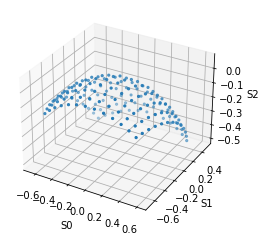

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ns = 20 # number of points to skip
ax.scatter(svec[0,::ns,::ns], svec[1,::ns,::ns], svec[2,::ns,::ns], marker='.')
ax.set_xlabel('S0')
ax.set_ylabel('S1')
ax.set_zlabel('S2')
plt.show()

### Symmetry

Space group information is stored in the `/entry/symmetry` group of `geometry.nxs`

In [17]:
symm = loadobj('geometry.nxs','symmetry')

Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry


The symmetry of the reciprocal space intensities is that of the Laue group (*m-3*). In *mdx2*, the Laue group operators are stored explicitly as 3x3 rotation matrices. For example:

In [18]:
op_index = 10 # there are 24 operators (index 0 to 23)
op = symm.laue_group_operators[op_index,:,:]
print(op)

[[ 0. -1.  0.]
 [ 0.  0.  1.]
 [-1.  0.  0.]]


The symmetry operators act on Miller indices according to rules of matrix multiplication

In [19]:
hkl = [4,3,2]
print(op @ hkl) # @ means matrix multiply

[-3.  2. -4.]


### Symmetry calculations

The reciprocal space asymmetric unit for Laue group *m-3* is defined as the following set of conditions:

In [20]:
print(symm.reciprocal_space_asu)

h>=0 and ((l>=h and k>h) or (l==h and k==h))


*mdx2* objects can use this information to do further symmetry calculations.

In [21]:
type(symm)

mdx2.geometry.Symmetry

We can use the `to_asu` function to map arbitrary h,k,l points into the asymmetric unit

In [22]:
# generate a grid of 27 h,k,l values
h,k,l = np.meshgrid([-1,0,1],[-1,0,1],[-1,0,1])
h = h.flatten() # so we can put them side-by-side in a table
k = k.flatten()
l = l.flatten()

# find position in the asu and the operator index n that took it there
h_asu,k_asu,l_asu,n = symm.to_asu(h,k,l)

# display as a table
df = pd.DataFrame({'h':h,'k':k,'l':l,'h_asu':h_asu,'k_asu':k_asu,'l_asu':l_asu,'op':n})
df

,h,k,l,h_asu,k_asu,l_asu,op
0,-1,-1,-1,1,1,1,12
1,-1,-1,0,0,1,1,6
2,-1,-1,1,1,1,1,6
3,0,-1,-1,0,1,1,4
4,0,-1,0,0,1,0,4
5,0,-1,1,0,1,1,11
6,1,-1,-1,1,1,1,3
7,1,-1,0,0,1,1,5
8,1,-1,1,1,1,1,19
9,-1,0,-1,0,1,1,9


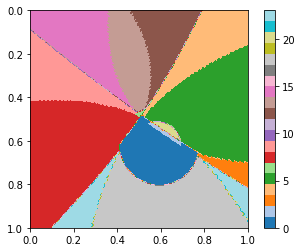

In [23]:
# for fun, lets visualize the asymmetric units on the detector face
nframe = 40 # <-- 0 to 60. change the frame and see what happens
h = mi.h[nframe,:,:]
k = mi.k[nframe,:,:] 
l = mi.l[nframe,:,:]
_,_,_,n = symm.to_asu(h,k,l)
plt.imshow(n,extent=[0,1,1,0],cmap="tab20")
plt.colorbar()

## Intensity statistics (*pandas*)

### Intensity vs. resolution

Load the corrected, unmerged data

In [5]:
# load table as mdx2 object
tab = loadobj('corrected.nxs','hkl_table')

# convert to pandas DataFrame
df = tab.to_frame().set_index(['h','k','l','op','n']).sort_index()

# show the first several rows
df.head()

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data


intensity  intensity_error           ix           iy  \
h   k    l     op n                                                          
0.0 0.25 2.75  10 0         NaN       3458472.25  1222.937500  1211.979126   
         3.00  10 0         NaN       4526965.50  1220.806396  1210.483887   
         3.25  10 0  38040624.0      19222264.00  1218.000000  1209.000000   
         19.75 10 0  55826468.0      25134906.00   958.000000  1023.750000   
         20.00 10 0  54929968.0      11178633.00   954.549988  1021.049988   

                            phi  rs_volume         s  
h   k    l     op n                                   
0.0 0.25 2.75  10 0  165.493744   0.000405  0.034724  
         3.00  10 0  165.672577   0.000274  0.037856  
         3.25  10 0  165.800003   0.000037  0.040990  
         19.75 10 0  165.949997   0.000209  0.248377  
         20.00 10 0  165.904999   0.001056  0.251520

Plot the mean and standard deviation of intensity vs. s

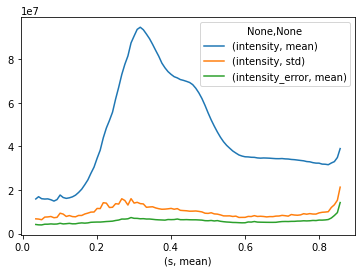

In [14]:
# divide into 100 equal sized bins
s_bins = pd.cut(df['s'],100)

# compute statistics in each bin
df_isoavg = df.groupby(s_bins).agg({
    's':'mean',
    'intensity':['mean','std'],
    'intensity_error':'mean'})

# plot statistics vs. s
df_isoavg.set_index(('s','mean')).plot();

### Correlation of half-datasets

A common way to determine data quality is to split the dataset in half, merge separately, and compute the correlation coefficient between the two halves.

There are different ways to split the data. In *mdx-lib* we split the data randomly such that each half has roughly equal statistical weight. The coefficient is called CC1/2. We haven't implemented the algorithm yet in *mdx2*. 

An simpler method is to split in reciprocal space. We'll just arbitrarily assign symmetry operators to one group or the other.

#### Split into half datasets

In [30]:
# load the table again
tab = loadobj('corrected.nxs','hkl_table')
df = tab.to_frame()

# split into two halves based on the symmetry operator
grouped = df.groupby(pd.cut(df['op'],2))

# save as nexus files for merging with mdx2.merge
for grp,filename in zip(grouped,('split_1.nxs','split_2.nxs')):
    print('interval:',grp[0])
    _tmp = HKLTable.from_frame(grp[1])
    _tmp.ndiv = tab.ndiv # need to add back the grid subdivision info
    saveobj(_tmp,filename)

interval: (-0.023, 11.5]
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to split_1.nxs
interval: (11.5, 23.0]
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to split_2.nxs


#### Merge the half datasets

In [36]:
!mdx2.merge split_1.nxs --scale scales.nxs --outfile merged_1.nxs
!mdx2.merge split_2.nxs --scale scales.nxs --outfile merged_2.nxs

Reading hkl_table from split_1.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_1.nxs
done!
Reading hkl_table from split_2.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged_2.nxs
done!


#### Compute the correlation coefficients

Load the half datasets merge them into one table

In [55]:
t1 = loadobj('merged_1.nxs','hkl_table')
t2 = loadobj('merged_2.nxs','hkl_table')

# computing scattering vector magnitude
Crystal = loadobj('geometry.nxs','crystal')
UB = Crystal.ub_matrix
s = UB @ np.stack((t1.h,t1.k,t1.l))
t1.s = np.sqrt(np.sum(s*s,axis=0))

# merge the two tables
df1 = t1.to_frame().set_index(['h','k','l'])
df2 = t2.to_frame().set_index(['h','k','l'])
df12 = df1.merge(df2,on=('h','k','l'),suffixes=('_1','_2'))
df12.head()

Reading hkl_table from merged_1.nxs
  importing as HKLTable from mdx2.data
Reading hkl_table from merged_2.nxs
  importing as HKLTable from mdx2.data
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry


count_1  intensity_1  intensity_error_1         s  count_2  \
h    k   l                                                                  
0.25 0.5 2.50       19   12998998.0       762653.56250  0.032214        9   
         2.75       28   12745830.0       321462.59375  0.035289       32   
         3.00       33   14997595.0       304689.31250  0.038374       35   
         3.25       32   14185853.0       315327.18750  0.041469       37   
         3.50       37   13687030.0       305594.96875  0.044570       34   

               intensity_2  intensity_error_2  
h    k   l                                     
0.25 0.5 2.50   12289400.0        809300.0625  
         2.75   12724568.0        353913.2500  
         3.00   14976032.0        325297.4375  
         3.25   14133615.0        302805.4375  
         3.50   13627308.0        309478.3750

Now, we just need to group by |s| and compute correlation in each one

<AxesSubplot:xlabel='s'>

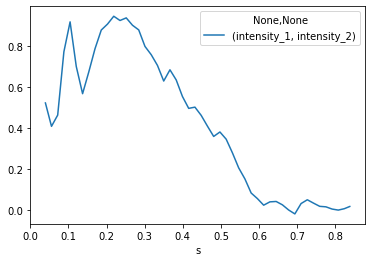

In [67]:
s_bin = pd.cut(df12.s,50)
corr_binned = df12.groupby(s_bin)['intensity_1','intensity_2'].corr(method='pearson').unstack()
corr_binned['s'] = df12.groupby(s_bin)['s'].mean()
corr_binned.plot(x='s',y=('intensity_1','intensity_2'))